In [0]:
import imageio
import cv2
import numpy as np
import os
import pickle
import re
import PIL
from PIL import Image

## Challenge Categories

In [0]:
CATEGORIES = [
    "boxing",
    "handclapping",
    "handwaving",
    "jogging",
    "running",
    "walking"
]

IMG_W = 60
IMG_H = 80
CHANNELS = 1
SEQ_LEN = 30
INPUT_SHAPE = (SEQ_LEN, IMG_W, IMG_H, CHANNELS)
NCLASSES = 6

EPOCHS = 25
BATCH_SIZE = 64

### Spliting Dataset

In [0]:
# Dataset are divided according to the instruction at:
# http://www.nada.kth.se/cvap/actions/00sequences.txt
TRAIN_PEOPLE_ID = [11, 12, 13, 14, 15, 16, 17, 18]
DEV_PEOPLE_ID = [19, 20, 21, 23, 24, 25, 1, 4]
TEST_PEOPLE_ID = [22, 2, 3, 5, 6, 7, 8, 9, 10]

## Loading Dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
print("Loading dataset ..")
train_videos = pickle.load(open("/content/drive/My Drive/DATASETS/KTH/Dataset pickles/train.p", "rb"))
dev_videos = pickle.load(open("/content/drive/My Drive/DATASETS/KTH/Dataset pickles/dev.p", "rb"))
test_videos = pickle.load(open("/content/drive/My Drive/DATASETS/KTH/Dataset pickles/test.p", "rb"))

Loading dataset ..


##Preparing dataset

In [0]:
def generate_sequences(ds="train"):
  if(ds == "dev"):
    videos = dev_videos
  elif (ds == "test"):
    videos = test_videos
  else:
    videos = train_videos
      
  X = []
  y = []
  for video in videos:
    frames = video["frames"]
    sequences = len(frames) // SEQ_LEN
    seq_frames = []
    sequnces_frames = [] 
    step = SEQ_LEN
    for i in range(0, len(frames)):
      if(i < step):
        seq_frames.append(frames[i])
      else:
        sequnces_frames.append(seq_frames)
        seq_frames = []
        step = step + SEQ_LEN + 1
    sequnces_frames = np.array(sequnces_frames[:sequences])
    for seq in sequnces_frames:
      X.append(seq.reshape(INPUT_SHAPE))
      y.append(CATEGORIES.index(video["category"]))

  X = np.array(X, dtype=np.float32)
  y = np.array(y, dtype=np.uint8)

  return X, y

In [0]:
X_train, y_train = generate_sequences(ds="train")
X_dev, y_dev = generate_sequences(ds="dev")
X_test, y_test = generate_sequences(ds="test")

In [8]:
X_train.shape

(2316, 30, 60, 80, 1)

In [9]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten
from keras.layers import Input, ZeroPadding2D, Conv2D, MaxPooling2D, Activation, add
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import plot_model

In [0]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_dev = to_categorical(y_dev)
y_test = to_categorical(y_test)

In [0]:
# CNN model (VGG-like)
model = Sequential()
weights_init = 'glorot_uniform'
## Stage 1
model.add(TimeDistributed(Conv2D(32, (3, 3), kernel_initializer=weights_init), input_shape=INPUT_SHAPE))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Conv2D(32,(3,3),activation='relu',padding='valid')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2),padding='valid')))

## Stage 2
model.add(TimeDistributed(Conv2D(64,(3,3),activation='relu',padding='valid')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Conv2D(64,(3,3),activation='relu',padding='valid')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2),padding='valid')))

## Stage 3
model.add(TimeDistributed(Conv2D(128,(3,3),activation='relu',padding='valid')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Conv2D(128,(3,3),activation='relu',padding='valid')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2),padding='valid')))

## Output
model.add(TimeDistributed(Flatten()))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(256,activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(512,activation='relu')))
model.add(Dropout(0.5))
model.add(LSTM(1024, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(NCLASSES,activation='softmax'))

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 58, 78, 32)    320       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 58, 78, 32)    128       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 56, 76, 32)    9248      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 56, 76, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 28, 38, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 26, 36, 64)    18496     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 26, 36, 64)   

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
trained_model = model.fit(X_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data=(X_dev, y_dev) , shuffle=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2316 samples, validate on 2256 samples
Epoch 1/25
2316/2316 [==============================] - 38s 16ms/step - loss: 1.3160 - acc: 0.4331 - val_loss: 1.2973 - val_acc: 0.4849
Epoch 2/25
2316/2316 [==============================] - 29s 12ms/step - loss: 0.7562 - acc: 0.6528 - val_loss: 1.0734 - val_acc: 0.6449
Epoch 3/25
2316/2316 [==============================] - 29s 12ms/step - loss: 0.5965 - acc: 0.7323 - val_loss: 1.1205 - val_acc: 0.6179
Epoch 4/25
2316/2316 [==============================] - 29s 12ms/step - loss: 0.5939 - acc: 0.7470 - val_loss: 1.0048 - val_acc: 0.6618
Epoch 5/25
2316/2316 [==============================] - 29s 12ms/step - loss: 0.4683 - acc: 0.7867 - val_loss: 1.7493 - val_acc: 0.6028
Epoch 6/25
2316/2316 [==============================] - 29s 12ms/step - loss: 0.4299 - acc: 0.8005 - val_loss: 0.8151 - val_acc: 0.6977
Epoch 7/25
2316/2316 [==================

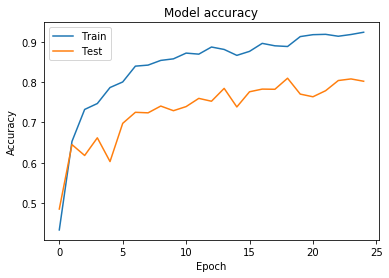

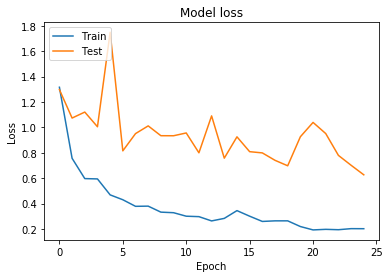

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Plot training & validation accuracy values
plt.plot(trained_model.history['acc'])
plt.plot(trained_model.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [18]:
model.evaluate(X_test, y_test)

2450/2450 [==============================] - 9s 4ms/step


[0.8366113256967189, 0.7587755102040816]

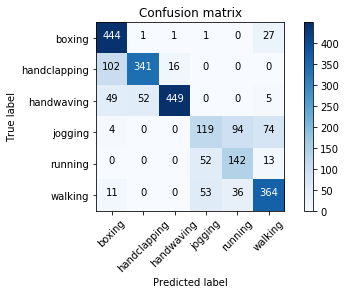

In [19]:
# Confusion matrix 
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = CATEGORIES) 

In [0]:
model.save_weights('LRCN_KTH.h5')

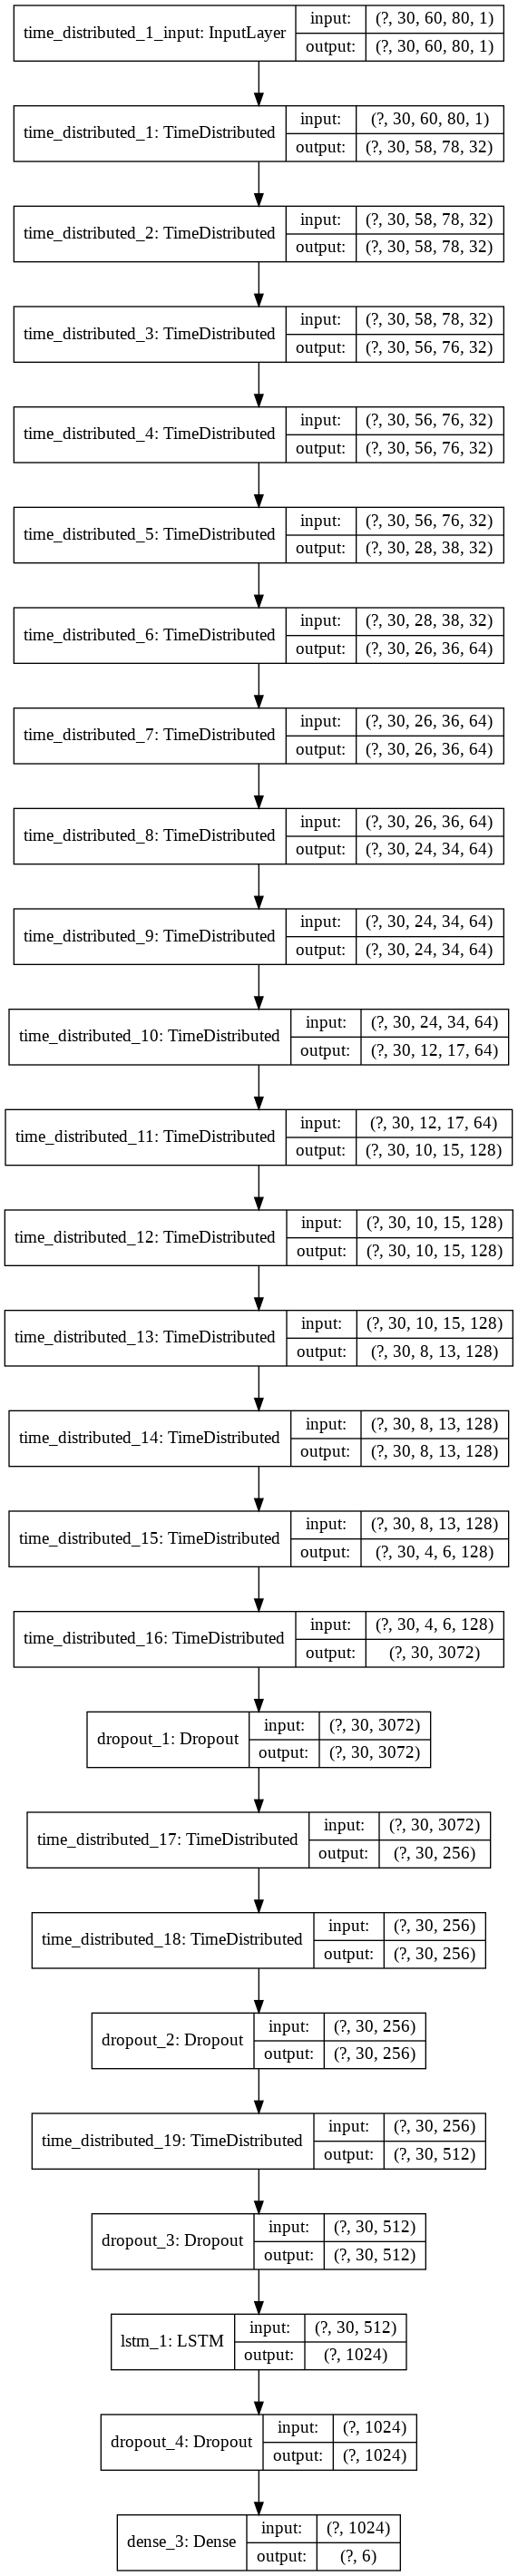

In [21]:
plot_model(model, show_shapes=True, to_file='LRCN_KTH.png')